# 🤔 Ensemble Learning은 Imbalanced Data에도 효과가 있을까?

## Import libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
# import fetch_california_housing as dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
import copy
from datetime import datetime
import torch.nn.functional as F  
import sys
import pandas as pd

## Parameters

In [2]:
rand_seed = 512

NUM_ENSEMBLE_MODELS = 6

## Dataset Distribution (Target Y) 확인

- Dataset을 확인하여 Imbalanced Data인지 확인하기 

In [3]:
def view_distribution(y):
    # View distribution
    sns.distplot(y)
    plt.xlabel('x values')
    plt.ylabel('Frequency')

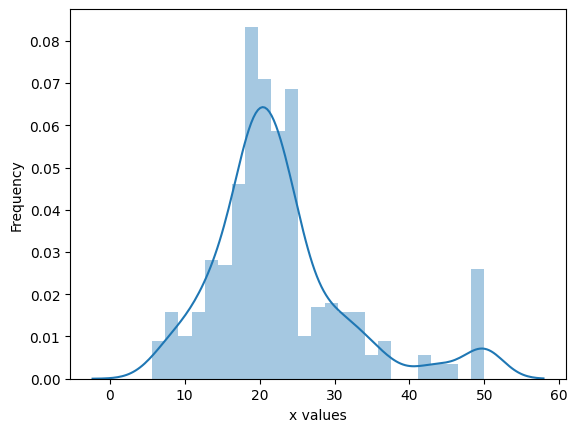

In [7]:
# dataset_name = 'diabetes'
# dataset_name = 'california_house'
dataset_name = 'boston_house'

if dataset_name == 'diabetes':
    x, y= datasets.load_diabetes(return_X_y=True)
    threshold_rare = 270
    EPOCHS = 3500
    TRAIN_BATCH = 2048
elif dataset_name == 'california_house':
    data = datasets.fetch_california_housing()
    x = data.data
    y = data.target
    threshold_rare = 3.5
    EPOCHS = 800
    TRAIN_BATCH = 4096 
elif dataset_name == 'boston_house':
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    x = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    threshold_rare = 35
    EPOCHS = 3500
    TRAIN_BATCH = 2048



np.random.seed(seed=rand_seed)
sample = np.random.choice(range(len(y)), 500)
x_sample, y_sample = x[sample,:], y[sample]


view_distribution(y_sample)


In [8]:
print("X shape")
print(x.shape)
print("Y shape")
print(y.shape)


X shape
(506, 13)
Y shape
(506,)


In [9]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=rand_seed, train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=rand_seed, train_size=0.8)

In [10]:
# scaling by minmax scaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)

In [11]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [12]:
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [13]:
y.reshape(-1,1).shape

(506, 1)

In [14]:
print("num train : ", len(y_train))
print("num valid : ", len(y_valid))
print("num test  : ", len(y_test))

num train :  323
num valid :  81
num test  :  102


## MLP 

In [15]:
BATCH_SIZE = 2048 
LEARNING_RATE = 0.001

NUM_INPUT = x_train.shape[1]
NUM_OUTPUT = 1 
NUM_1ST_HIDDEN = 32 
NUM_2ND_HIDDEN = 16 
NUM_1ST_DROPOUT = 0.6
NUM_2ND_DROPOUT = 0.5

In [16]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    


In [17]:
train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
valid_data = TrainData(torch.FloatTensor(x_valid), torch.FloatTensor(y_valid))
test_data = TestData(torch.FloatTensor(x_test))

train_loader = DataLoader(dataset=train_data, batch_size=TRAIN_BATCH, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=256)
valid_loader = DataLoader(dataset=valid_data, batch_size=1024)

In [18]:
class BasicRegressor(nn.Module):
    def __init__(self) -> None:
        super(BasicRegressor, self).__init__()

        self.layer_1 = nn.Linear(NUM_INPUT, NUM_1ST_HIDDEN)
        self.layer_2 = nn.Linear(NUM_1ST_HIDDEN, NUM_2ND_HIDDEN)
        self.layer_out = nn.Linear(NUM_2ND_HIDDEN, NUM_OUTPUT)

        # self.actvation = nn.ReLU()
        self.actvation_1 = nn.ReLU()
        self.actvation_2 = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=NUM_1ST_DROPOUT)
        self.dropout_2 = nn.Dropout(p=NUM_2ND_DROPOUT)
        self.batchnorm_1 = nn.BatchNorm1d(NUM_1ST_HIDDEN)
        self.batchnorm_2 = nn.BatchNorm1d(NUM_2ND_HIDDEN)
    
    def forward(self, inputs):
        x = self.actvation_1(self.layer_1(inputs))
        x = self.batchnorm_1(x)
        x = self.dropout_1(x)
        x = self.actvation_2(self.layer_2(x))
        x = self.batchnorm_2(x)
        x = self.dropout_2(x)
        x = self.layer_out(x)

        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device='cpu'

cuda:0


In [19]:
model = BasicRegressor()
model.to(device)

print(model)


# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BasicRegressor(
  (layer_1): Linear(in_features=13, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (actvation_1): ReLU()
  (actvation_2): ReLU()
  (dropout_1): Dropout(p=0.6, inplace=False)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
def train_model(num_train_data, num_eval_data):

    best_loss_on_valid = 999999999
    best_model = None

    for epoch in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0

        eval_epoch_loss = 0
        eval_epoch_acc = 0

        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)
        # acc = calc_accuracy(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        # epoch_acc += acc.item()
    
        if epoch % 10 == 0:
            with torch.no_grad():
                model.eval()
                for x, y in valid_loader:
                    x = x.to(device)
                    y = y.to(device)

                    output = model(x)

                    eval_loss = criterion(output, y)
                # eval_acc = calc_accuracy(output, y)

                    eval_epoch_loss += eval_loss.item()
                # eval_epoch_acc += eval_acc.item()
        
            if best_loss_on_valid >= (eval_epoch_loss/num_eval_data):
                best_loss_on_valid = (eval_epoch_loss/num_eval_data)
                best_model = copy.deepcopy(model)
                print("Best Model is copied - Best Loss : ", best_loss_on_valid)
        


            print(f"Epoch {epoch+0:03}: : Loss: T_{epoch_loss/num_train_data:.3f} V_{eval_epoch_loss/num_eval_data:.3f} | Acc: T_{epoch_acc/num_train_data:.3f}) V_{eval_epoch_acc/num_eval_data:.3f}")
    return best_model


In [21]:
def calc_loss(y_pred, y_test):
    mse_criterion = nn.L1Loss() 
    mse = mse_criterion(y_pred, y_test)

    return mse 

In [22]:
def calc_l1(y_pred, y_test):
    return np.abs(y_pred - y_test)

In [23]:
num_train_data = len(train_loader)
num_eval_data = len(valid_loader)


elapsed_time_basic_ann = []

start_time = datetime.now()


best_model = train_model(num_train_data, num_eval_data)


elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

Best Model is copied - Best Loss :  595.6517944335938
Epoch 010: : Loss: T_595.416 V_595.652 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  591.7857055664062
Epoch 020: : Loss: T_591.108 V_591.786 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  589.2391357421875
Epoch 030: : Loss: T_585.663 V_589.239 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  587.8569946289062
Epoch 040: : Loss: T_581.048 V_587.857 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  586.8801879882812
Epoch 050: : Loss: T_579.342 V_586.880 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  585.6203002929688
Epoch 060: : Loss: T_577.749 V_585.620 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  583.6187133789062
Epoch 070: : Loss: T_574.509 V_583.619 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  580.8402099609375
Epoch 080: : Loss: T_569.942 V_580.840 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  577.9957885742188
Epoch 090:

In [24]:
best_model.eval()
data = torch.from_numpy(x_test).float().to(device)
answer = torch.from_numpy(y_test).float().to(device)

# data = torch.from_numpy(x_train).float().to(device)
# answer = torch.from_numpy(y_train_onehot).float().to(device)

# data = torch.from_numpy(x_valid).float().to(device)
# answer = torch.from_numpy(y_valid_onehot).float().to(device)

start_time = datetime.now()
output = best_model(data)
loss_basic_ann = calc_loss(output, answer)
elapsed_time_basic_ann.append((datetime.now()-start_time).total_seconds())

# print('Accuracy ', acc_basic_ann)
print('elapsed time ', elapsed_time_basic_ann)

elapsed time  [27.547154, 0.004993]


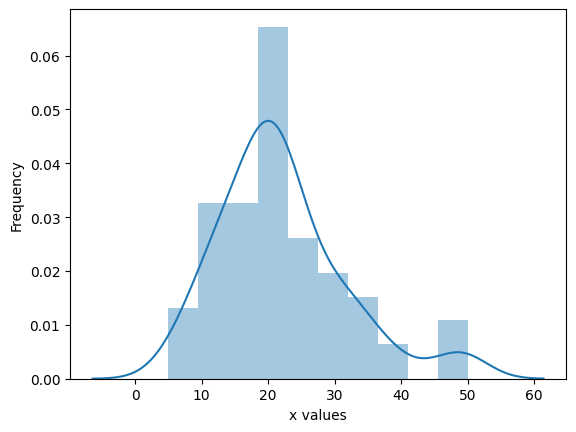

In [25]:
view_distribution(answer.cpu().detach().numpy())

In [26]:
def calc_l1_loss_by_shots(output, answer):
    l1_loss = calc_l1(output, answer)
    rare_indicies = np.where(y_test>threshold_rare)[0]
    # print(rare_indicies)


    normal_indicies = np.where(y_test<=threshold_rare)[0]
    # print(normal_indicies)


    avg_rare_l1 = np.average(l1_loss[rare_indicies])
    avg_normal_l1 = np.average(l1_loss[normal_indicies])
    avg_total_l1 = np.average(l1_loss)

    return avg_rare_l1, avg_normal_l1, avg_total_l1

In [27]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(output.cpu().detach().numpy(), answer.cpu().detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  8.094698
Normal Loss  2.0786624
Total Loss  2.6094892


## Ensemble MLP 

In [29]:
best_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = BasicRegressor()
    model.to(device)

    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    bagg_indices = np.random.choice(range(len(x_train)), len(x_train), replace=True)

    x_train_bagg = x_train[bagg_indices, :]
    y_train_bagg = y_train[bagg_indices, :]
    # train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    train_data = TrainData(torch.FloatTensor(x_train_bagg), torch.FloatTensor(y_train_bagg))
    train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)


    num_train_data = len(train_loader)
    num_eval_data = len(valid_loader)


    elapsed_time_basic_ann = []
    start_time = datetime.now()

    best_model = train_model(num_train_data, num_eval_data)

    best_models.append(best_model)



Best Model is copied - Best Loss :  590.6981201171875
Epoch 010: : Loss: T_574.288 V_590.698 | Acc: T_0.000) V_0.000
Epoch 020: : Loss: T_573.020 V_591.486 | Acc: T_0.000) V_0.000
Epoch 030: : Loss: T_569.653 V_590.789 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  588.5795288085938
Epoch 040: : Loss: T_565.443 V_588.580 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  584.2538452148438
Epoch 050: : Loss: T_560.212 V_584.254 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  580.2279052734375
Epoch 060: : Loss: T_556.078 V_580.228 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  573.5448608398438
Epoch 070: : Loss: T_554.547 V_573.545 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  565.6581420898438
Epoch 080: : Loss: T_545.094 V_565.658 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  561.2141723632812
Epoch 090: : Loss: T_540.365 V_561.214 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  559.1353759765625
E

In [30]:
# inference
sum_output = np.zeros(y_test.shape)

for best_model in best_models:
    best_model.eval()
    output = best_model(data)
    sum_output += output.cpu().detach().numpy()

avg_output = sum_output / len(best_models)


In [31]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(avg_output, answer.cpu().detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  7.076410788076895
Normal Loss  2.062248190671312
Total Loss  2.504674302207099


## Ensemble MLP with REBAGG (REsampling Bagging Method, 2018, P Branco)

In [33]:
relevance_value = threshold_rare


In [34]:
rare_indicies = np.where(y_train>threshold_rare)[0]
normal_indicies = np.where(y_train<=threshold_rare)[0]

ov_rare_indicies = np.random.choice(range(len(rare_indicies)), len(normal_indicies), replace=True)

x_train_normal_bagg = x_train[normal_indicies, :]
y_train_normal_bagg = y_train[normal_indicies, :]


x_train_rare_bagg = x_train[ov_rare_indicies, :]
y_train_rare_bagg = y_train[ov_rare_indicies, :]



In [35]:
best_models = []
for i in range(NUM_ENSEMBLE_MODELS):
    model = BasicRegressor()
    model.to(device)

    # criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    bagg_indices = np.random.choice(range(len(x_train)), len(x_train), replace=True)
    # x_train_bagg = x_train[bagg_indices, :]
    # y_train_bagg = y_train[bagg_indices, :]

    rare_indicies = np.where(y_train>threshold_rare)[0]
    normal_indicies = np.where(y_train<=threshold_rare)[0]

    ov_rare_indicies = np.random.choice(range(len(rare_indicies)), len(normal_indicies), replace=True)

    x_train_normal_bagg = x_train[normal_indicies, :]
    y_train_normal_bagg = y_train[normal_indicies, :]


    x_train_rare_bagg = x_train[rare_indicies, :]
    y_train_rare_bagg = y_train[rare_indicies, :]


    x_train_total_bagg = np.append(x_train_normal_bagg, x_train_rare_bagg, axis=0)
    y_train_total_bagg = np.append(y_train_normal_bagg, y_train_rare_bagg, axis=0)

    

    
    # train_data = TrainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    train_data = TrainData(torch.FloatTensor(x_train_total_bagg), torch.FloatTensor(y_train_total_bagg))
    train_loader = DataLoader(dataset=train_data, batch_size=2048, shuffle=True)


    num_train_data = len(train_loader)
    num_eval_data = len(valid_loader)


    elapsed_time_basic_ann = []
    start_time = datetime.now()

    best_model = train_model(num_train_data, num_eval_data)

    best_models.append(best_model)



Best Model is copied - Best Loss :  586.3316040039062
Epoch 010: : Loss: T_580.549 V_586.332 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  581.8206176757812
Epoch 020: : Loss: T_576.885 V_581.821 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  579.318359375
Epoch 030: : Loss: T_571.753 V_579.318 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  576.6486206054688
Epoch 040: : Loss: T_570.049 V_576.649 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  573.351806640625
Epoch 050: : Loss: T_568.845 V_573.352 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  569.99462890625
Epoch 060: : Loss: T_560.911 V_569.995 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  568.5916137695312
Epoch 070: : Loss: T_558.895 V_568.592 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  565.3417358398438
Epoch 080: : Loss: T_554.017 V_565.342 | Acc: T_0.000) V_0.000
Best Model is copied - Best Loss :  560.4815063476562
Epoch 090: : Loss

In [36]:
# inference
sum_output = np.zeros(y_test.shape)

for best_model in best_models:
    best_model.eval()
    output = best_model(data)
    sum_output += output.cpu().detach().numpy()

avg_output = sum_output / len(best_models)


In [37]:
print(len(best_models))

6


In [38]:
rare_loss, normal_loss, total_loss = calc_l1_loss_by_shots(avg_output, answer.cpu().detach().numpy())
print("Rare Loss ", rare_loss)
print("Normal Loss ", normal_loss)
print("Total Loss ", total_loss)

Rare Loss  7.119301442746765
Normal Loss  1.9681644721697733
Total Loss  2.422676557808919


In [45]:
answer[44]

tensor([20.1000], device='cuda:0')

In [46]:
avg_output[44]

array([17.31996314])